In [2]:
import os
import tqdm
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

Data preprocess

In [3]:
def encode_seq(seq):
    encoding_list = []
    for i in range(len(seq)):
        if seq[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        elif seq[i] == "_":
            # print("Error: seqCDR contains '_'")
            # encoding_list.append(np.zeros(5).reshape(1,5))
            return np.nan
        else:
            encoding_list.append(af.loc[seq[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [4]:
class TCREncodeData(Dataset):
    '''
    The class defines the dataset used to encode TCR sequence data
    If the dataset is 
    '''
    def __init__(self, file_path):
        df = pd.read_csv(file_path, index_col=0)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seq(x))
        
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep='first')
        df = df.drop_duplicates(subset=["AseqCDR3"], keep="first")
        df = df.drop_duplicates(subset=["BseqCDR3"], keep="first")

        df = df.loc[df["AseqCDR3"].str.len() < 50, :]

        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        print(len_map)

        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(
                lambda x: x + "*" * (length - len(x))
            )
            df[chain] = df[chain].apply(lambda x: encode_seq(x))
        
        df = df.dropna()
        print(df.shape)

        X_features = torch.zeros((len(df), 0))
        for seq in ["AseqCDR3", "BseqCDR3"]:
            X_features = torch.cat((X_features, torch.from_numpy(
                np.vstack(df[seq].values)
            )), dim=1)
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

        self.X_features = X_features
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X_features[index], self.y[index]

TCR encoding

In [5]:
class TCR_autoencoder(nn.Module):
    '''
    Param:
        input_size: the input feature size
        hidden_size: the size of hidden variable
        output_size: the size of output features
    '''
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (batch_size, 5, 49)
            nn.Conv1d(5, 10, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 10, 25) based on the formula for conv1d: (W + 2P - K)/S + 1 = (49 + 2*1 - 3)/2 + 1 = 25
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 10, 23), 25 - 2 = 23 

            nn.Conv1d(10, 15, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 12) based on the formula for conv1d: (W + 2P - K)/S + 1 = (23 + 2*1 - 3)/2 + 1 = 12
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 10), 12 - 2 = 10

            nn.Conv1d(15, 20, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 5) based on the formula for conv1d: (W + 2P - K)/S + 1 = (10 + 2*1 - 3)/2 + 1 = 5
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 3)

            nn.Conv1d(20, 20 , kernel_size=5, stride=stride, padding=padding),
            # (batch_size, 20, 1) based on the formula for conv1d: (W + 2P - K)/S + 1 = (3 + 2*1 - 5)/2 + 1 = 1
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            # (batch_size, 20, 1)
            nn.ConvTranspose1d(20, 20, kernel_size=5, stride=2, padding=1),
            # (batch_size, 20, 3), based on the formula for convtranspose1d: (W−1)S−2P+F = (1-1)*2-2*1+5= 3
            nn.LeakyReLU(),

            nn.ConvTranspose1d(20, 15, kernel_size=3, stride=3, padding=1),
            # (batch_size, 15, 5), based on the formula for convtranspose1d: (W−1)S−2P+F = (3-1)*3-2*1+3= 7
            nn.LeakyReLU(),

            nn.ConvTranspose1d(15, 10, kernel_size=7, stride=3, padding=1),
            # (batch_size, 10, 23) based on the formula for convtranspose1d: (W−1)S−2P+F = (7-1)*3-2*1+7= 23
            nn.LeakyReLU(),

            nn.ConvTranspose1d(10, 5, kernel_size=7, stride=2, padding=1),
            # (batch_size, 5, 49) based on the formula for convtranspose1d: (W−1)S−2P+F = (23-1)*2-2*1+7= 49
            nn.LeakyReLU(),
        )

    def forward(self, input):
        # x = torch.tensor(x, dtype=np.float32)
        # x = torch.tensor(x, dtype=torch.float)
        x = input.float()
        encoded = self.encoder(x)
        # print(f"encoding shape: {encoded.shape}")
        encoded = encoded.float()
        output = self.decoder(encoded)
        # print(f"output shape: {output.shape}")
        return encoded, output

In [6]:
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCREncodeData(file_path)

{'AseqCDR3': 25, 'BseqCDR3': 24}
(2358, 6)


Train Epoch: 1 [0/2358 (0%)]	Loss: 1.297911
Train Epoch: 1 [1600/2358 (68%)]	Loss: 1.275421
Train Epoch: 2 [0/2358 (0%)]	Loss: 1.290722
Train Epoch: 2 [1600/2358 (68%)]	Loss: 1.378245
Train Epoch: 3 [0/2358 (0%)]	Loss: 1.242732
Train Epoch: 3 [1600/2358 (68%)]	Loss: 1.217479
Train Epoch: 4 [0/2358 (0%)]	Loss: 1.148395
Train Epoch: 4 [1600/2358 (68%)]	Loss: 1.132191
Train Epoch: 5 [0/2358 (0%)]	Loss: 1.264346
Train Epoch: 5 [1600/2358 (68%)]	Loss: 1.163525
Train Epoch: 6 [0/2358 (0%)]	Loss: 1.191676
Train Epoch: 6 [1600/2358 (68%)]	Loss: 1.279669
Train Epoch: 7 [0/2358 (0%)]	Loss: 1.163980
Train Epoch: 7 [1600/2358 (68%)]	Loss: 1.125402
Train Epoch: 8 [0/2358 (0%)]	Loss: 1.141288
Train Epoch: 8 [1600/2358 (68%)]	Loss: 1.092539
Train Epoch: 9 [0/2358 (0%)]	Loss: 1.077902
Train Epoch: 9 [1600/2358 (68%)]	Loss: 1.209717
Train Epoch: 10 [0/2358 (0%)]	Loss: 1.125266
Train Epoch: 10 [1600/2358 (68%)]	Loss: 1.281549
Train Epoch: 11 [0/2358 (0%)]	Loss: 1.049173
Train Epoch: 11 [1600/2358 (68%)]

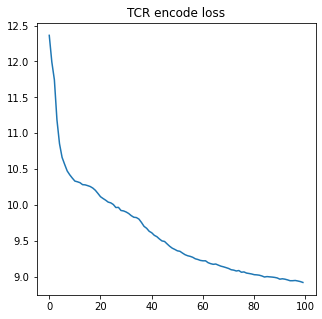

In [7]:
def train_autoencoder(model, train_loader, optimizer, criterion, epoch, seq_length):
    model.train()
    batch_loss = 0
    # model_accuracy = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, 5, seq_length)
        optimizer.zero_grad()
        _, output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        # TCR_encode_losses.append(loss.item() / model.batch_size)
        # TCR_encode_losses.append(loss.item())
        # sum up batch loss
        batch_loss += loss.item()
        # update the accuracy of the model
        # pred = output.data.max(1, keepdim=True)[1]
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            # print(f"The accuracy of the model is ")
            
    # return batch_loss / len(train_loader.dataset)
    return batch_loss / len(data)

# parameters setting
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1
seq_length = int(TCRData[0][0].shape[0] / 5)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train the autoencoder
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
train_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)

# plot the loss
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

TCR_encode_losses = []
TCR_accuracy = 0
for epoch in range(1, epochs + 1):
    TCR_encode_loss = train_autoencoder(model, train_loader, optimizer, criterion, epoch, seq_length)
    TCR_encode_losses.append(TCR_encode_loss)
ax.set_title("TCR encode loss")
ax.plot(TCR_encode_losses, label="TCR encode loss")

In [8]:
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1

model.eval()

# encode the TCR sequence
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCREncodeData(file_path)
# TCR_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)
TCR_encode = torch.zeros((0, 20, 1))
for i in range(len(TCRData)):
    TCR_seq = TCRData[i][0]
    encode_shape = int(TCR_seq.shape[0] / 5)
    TCR_seq = TCR_seq.view(1, 5, encode_shape).float()
    encoded, _ = model(TCR_seq)
    TCR_encode = torch.cat((TCR_encode, encoded), dim=0)

{'AseqCDR3': 25, 'BseqCDR3': 24}
(2358, 6)


In [9]:
class pMHC_TCRDataset(Dataset):
    '''
    The dataset for the encoded features of TCR sequence, and the Atchley factor of neoantigen sequence, and the HLA one-hot encoding.
    Here the input is the TCR sequence, neoantigen sequence, and HLA type.
    The output should be the encoded features of TCR sequence, and the Atchley factor of neoantigen sequence, and the HLA one-hot encoding.
    '''
    def __init__(self, 
                 file_path, 
                 only_CDR3: bool = False, 
                 only_experimental: bool = False, 
                 TCR_encode: str = ["LSTM", "CNN"],
                 encoding_model: nn.Module = None,
                 encoding_size: int = 20,
                 random_state: int = 123) -> None:
        df, HLA_encode, y, feature_size  = self.basic_io(file_path, only_experimental=only_experimental)

        
        # convert from object to tensor
        X_TCR_seq = torch.zeros((len(df), 0))
        for region in ["AseqCDR3", "BseqCDR3"]:
            TCR_seq = df.loc[:, region].values
            TCR_seq_encode = torch.zeros((0, TCR_seq[0].shape[1]))
            for i in range(len(TCR_seq)):
                encoding = torch.from_numpy(TCR_seq[i][0])
                encoding = encoding.reshape(1, -1)
                TCR_seq_encode = torch.cat((TCR_seq_encode, encoding), dim=0)

            X_TCR_seq = torch.cat((TCR_seq_encode, X_TCR_seq), dim=1)
        print(f"X_TCR_seq shape {X_TCR_seq.shape}")
        if TCR_encode == "CNN":
            X_TCR_seq = X_TCR_seq.view(-1, 5, feature_size)
        elif TCR_encode == "LSTM":
            X_TCR_seq = X_TCR_seq.view(-1, 5, feature_size)
        else:
            raise ValueError("The TCR encoding method is not supported yet.")
        
        # encoding model 
        X_features, _ = encoding_model(X_TCR_seq)
        X_features = X_features.view(-1, encoding_size).data

        # add the neoantigen sequence encoding features
        for seq in ["Neo_first3", "Neo_last3"]:
            neo = df.loc[:, seq].values
            neo_encode = torch.zeros((0, neo[0].shape[1]))
            for i in range(len(neo)):
                encoding = torch.from_numpy(neo[i][0])
                encoding = encoding.reshape(1, -1)
                neo_encode = torch.cat((neo_encode, encoding), dim=0)
            X_features = torch.cat((X_features, neo_encode), dim=1)

        X_features = torch.cat((X_features, torch.from_numpy(HLA_encode)), dim=1)


        self.X_features = X_features
        self.y = torch.from_numpy(y)

        # self.X_train, self.X_val, self.y_train, self.y_val = 
    
    def basic_io(self, file_path, only_experimental=True):
        # return the dataframe, contain the 
        df = pd.read_csv(file_path, index_col=0)
        df = df.loc[df["AseqCDR3"].str.len() < 50, :]
        # drop the random generate samples and duplicated 
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
        # df = df[df["AseqCDR3"].str.contains("_")==False].drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")

        # for chain in ["AseqCDR", "BseqCDR"]:
        #     if only_CDR3:
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        #     else:
        #         df[chain+"_1"] = df[chain].str.split("_").str[0]
        #         df[chain+"_2"] = df[chain].str.split("_").str[1]
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seq(x))

        # encode the CDR3 region
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        input_feature_size = sum(len_map.values())

        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seq(x))
        
        # drop the rows with nan
        df = df.dropna()
        if not only_experimental:
            df_ps = df[df["Class"] == "positive"]
            # df_ng_ex = df[df["Class"] == "negative"]
            df_ng_em = df.copy()
            df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
            df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
            df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
            # df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
            # df_ng.index = range(len(df_ng))
            df = pd.concat([df_ps, df_ng_em], axis=0)

        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0)
        y.value_counts().plot.pie(autopct='%.2f')
        return df, X_HLA_encoded, y.values, input_feature_size

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_features[idx], self.y[idx]

In [11]:
TCRData = pMHC_TCRDataset(file_path, TCR_encode="CNN", only_experimental=False, encoding_model=model)